In [28]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import statsmodels.api as sm
import seaborn as sns
import warnings

from collections import Counter
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import anderson
from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import spearmanr
from scipy.stats import norm
from scipy.integrate import quad
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator
from pgmpy.independencies import IndependenceAssertion
from pgmpy.inference import VariableElimination
from astroML.plotting import hist
from astroML.density_estimation import bayesian_blocks


warnings.filterwarnings("ignore")

In [2]:
print(os.getcwd())
os.chdir('C:/Users/andre/Job Portfolio Projects/DataGlacierVI/eda.project/datasets')
os.getcwd()

C:\Users\andre\Job Portfolio Projects\DataGlacierVI\bayesian.networks


'C:\\Users\\andre\\Job Portfolio Projects\\DataGlacierVI\\eda.project\\datasets'

In [3]:
# Load the dataset
df0 = pd.read_csv('mdf.csv')


## Estimating Non-Normal Distributions of Random Variables From Cab Data

In [ ]:
# Separate continuous from categorical
continuous = ['trip_miles', 'price', 'cost', 'profit']
categorical = ['company', 'city', 'state', 'payment_type', 'gender', 'quarter', 'day_of_week', 'age_category']

## Discovering Significant Relationships

In [34]:
# Check continuous variables for normality using Shapiro-Wilk

results_lst = []
for dist in continuous:

    stat, p = shapiro(df0[dist])

    print(f"Test Statistic for {dist}: {stat:.4f}")
    print(f"P-value for {dist}: {p:.4f}")

    if p > 0.05:
        print("Sample is normally distributed (fail to reject H0)")
    else:
        print("Sample is not normally distributed (reject H0)\n")

Test Statistic for trip_miles: 0.9631
P-value for trip_miles: 0.0000
Sample is not normally distributed (reject H0)

Test Statistic for price: 0.9466
P-value for price: 0.0000
Sample is not normally distributed (reject H0)

Test Statistic for cost: 0.9688
P-value for cost: 0.0000
Sample is not normally distributed (reject H0)

Test Statistic for profit: 0.8098
P-value for profit: 0.0000
Sample is not normally distributed (reject H0)



In [35]:
# Check for normality using Anderson-Darling
# at different significance levels

for var in continuous:
    result = anderson(df0[var])
    print("Statistic:", result.statistic)
    
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            print(f"{sl}%: data is normal (fail to reject H0)\n")
        else:
            print(f"{sl}%: data is not look normal (reject H0)\n")
        

Statistic: 3343.131378807244
15.0%: data is not look normal (reject H0)

10.0%: data is not look normal (reject H0)

5.0%: data is not look normal (reject H0)

2.5%: data is not look normal (reject H0)

1.0%: data is not look normal (reject H0)

Statistic: 3912.6614562623436
15.0%: data is not look normal (reject H0)

10.0%: data is not look normal (reject H0)

5.0%: data is not look normal (reject H0)

2.5%: data is not look normal (reject H0)

1.0%: data is not look normal (reject H0)

Statistic: 2766.122295228066
15.0%: data is not look normal (reject H0)

10.0%: data is not look normal (reject H0)

5.0%: data is not look normal (reject H0)

2.5%: data is not look normal (reject H0)

1.0%: data is not look normal (reject H0)

Statistic: 20527.323641635827
15.0%: data is not look normal (reject H0)

10.0%: data is not look normal (reject H0)

5.0%: data is not look normal (reject H0)

2.5%: data is not look normal (reject H0)

1.0%: data is not look normal (reject H0)



In [29]:
# Since normality assumption does not hold we use spearmanr for correlation
# All relationships are significant with a p-value < .05
for i in range(len(continuous)):
    x_input = continuous[i]
    for j in range(len(continuous)):
        y_output = continuous[j]
        if x_input == y_output:
            continue
        else:
            corr_coeff, p_value = spearmanr(df0[x_input], df0[y_output])
            print(f'{x_input} -vs- {y_output}: {corr_coeff:.2f}, p_value: {p_value:.4f}')

trip_miles -vs- price: 0.89, p_value: 0.0000
trip_miles -vs- cost: 0.98, p_value: 0.0000
trip_miles -vs- profit: 0.49, p_value: 0.0000
price -vs- trip_miles: 0.89, p_value: 0.0000
price -vs- cost: 0.91, p_value: 0.0000
price -vs- profit: 0.79, p_value: 0.0000
cost -vs- trip_miles: 0.98, p_value: 0.0000
cost -vs- price: 0.91, p_value: 0.0000
cost -vs- profit: 0.50, p_value: 0.0000
profit -vs- trip_miles: 0.49, p_value: 0.0000
profit -vs- price: 0.79, p_value: 0.0000
profit -vs- cost: 0.50, p_value: 0.0000


In [30]:
# ANOVA for all categorical variables against profits
# Resutls are stored in 'result_lst'

result_lst = []
for category in categorical:
    
    # Create a model using ordinary least squares (OLS)
    model = ols(f'profit ~ {category}', data=df0).fit()
    
    # Perform the ANOVA test
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    # Perform Tukey's HSD test
    tukey_results = sm.stats.multicomp.pairwise_tukeyhsd(endog=df0['profit'], groups=df0[category])
    
    # Append results to list
    result_lst.append([anova_table, tukey_results])
    


In [31]:

# Does Gender affect profits?
# Yes, we reject the null hypothesis with a p-value < .05

print(result_lst[4][1])

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
female   male   6.8649   0.0 5.8056 7.9242   True
-------------------------------------------------


In [39]:
# Perform Kruskal-Wallis test is a non-parametric test used when normality assumption
# does not hold for the continuous random variables and is like the ANOVA



for var1 in continuous:
    target = var1
    for var2 in categorical:
        # Group 'profit' data by 'day_of_week'
        grouped_data = df0.groupby(var2)[target].apply(list)

        # Perform Kruskal-Wallis test
        h_statistic, p_value = kruskal(*grouped_data)

        # Print results
        print("Kruskal-Wallis Test:")
        print("H-Statistic:", h_statistic)
        print("P-Value:", p_value)

        if p_value < 0.05:
            print(f"Reject null hypothesis: {var1} affects '{target}'.\n")
        else:
            print(f"Fail to reject null hypothesis: No significant effect of {var1} on '{target}'.\n")


Kruskal-Wallis Test:
H-Statistic: 0.030637185402586465
P-Value: 0.861052279811051
Fail to reject null hypothesis: No significant effect of trip_miles on 'trip_miles'.

Kruskal-Wallis Test:
H-Statistic: 21.205663611639487
P-Value: 0.2691643519106338
Fail to reject null hypothesis: No significant effect of trip_miles on 'trip_miles'.

Kruskal-Wallis Test:
H-Statistic: 13.198918384993478
P-Value: 0.3547498266262515
Fail to reject null hypothesis: No significant effect of trip_miles on 'trip_miles'.

Kruskal-Wallis Test:
H-Statistic: 0.25734984718319615
P-Value: 0.6119467191373807
Fail to reject null hypothesis: No significant effect of trip_miles on 'trip_miles'.

Kruskal-Wallis Test:
H-Statistic: 0.6796485874325718
P-Value: 0.4097077580272134
Fail to reject null hypothesis: No significant effect of trip_miles on 'trip_miles'.

Kruskal-Wallis Test:
H-Statistic: 2.241007591618547
P-Value: 0.5239163836118337
Fail to reject null hypothesis: No significant effect of trip_miles on 'trip_miles'

In [41]:
# Looking for quadratic relationships, exploratory data analysis project suggested there 
# was a quadratic trend in profits.

# R-squared for a quadratic model measures the proportion of the variance in the dependent 
# variable that is explained by the combination of the linear and quadratic terms of the independent variable. 
# Looking at the results the model does not fit well

X = df0['trip_miles'].values.reshape(-1, 1)
y = df0['profit']

degree = 2  # Quadratic polynomial

poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)


# Calculate R-Squared
correlation_coefficient = model.score(X_poly, y)  

# Coefficients of the regression equation
coefficients = model.coef_

# Display results
print("Polynomial Correlation Analysis Results:\n")
print("Correlation Coefficient:", correlation_coefficient)
print("\nRegression Equation:")
print(f"variable_y = {coefficients[0]:.4f} + {coefficients[1]:.4f} * variable_x + {coefficients[2]:.4f} * variable_x^2\n")


Polynomial Correlation Analysis Results:

Correlation Coefficient: 0.2141663285564841

Regression Equation:
variable_y = 0.0000 + 10.0556 * variable_x + -0.0103 * variable_x^2

Results and Interpretation:
...


## Chi-Square Test of Independence

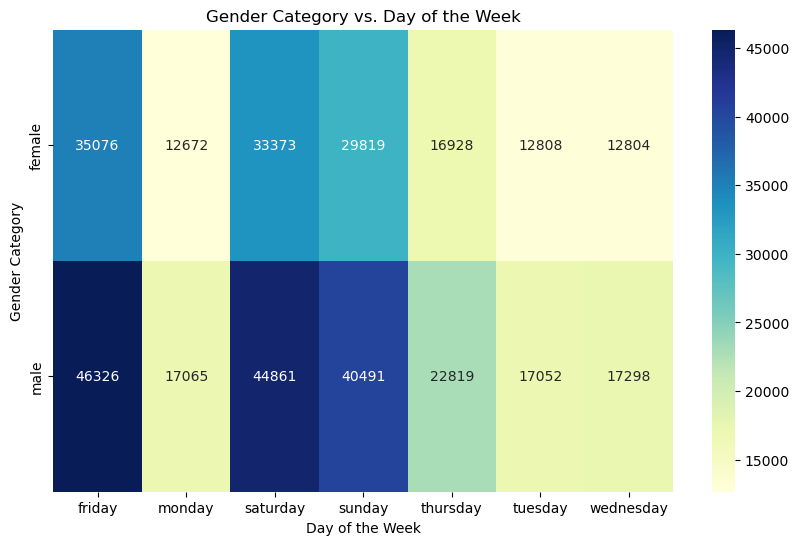

In [45]:

# Create a bigger heatmap with number formatting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

sns.heatmap(pd.crosstab(df0['gender'], df0['day_of_week']), annot=True, fmt='d', cmap='YlGnBu')  # 'd' for regular numbers

warnings.filterwarnings('ignore')
plt.title("Gender Category vs. Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Gender Category")

plt.show()

In [43]:


# Create a copy of the categorical list and reverse it
reverse_categorical = categorical.copy()
reverse_categorical.reverse()

for var1 in categorical:
    target = var1
    for var2 in reverse_categorical:
        contingency_table = pd.crosstab(df0[target], df0[var2])
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        print("Chi-squared:", chi2)
        print("p-value:", p, '\n')


        if p < 0.05:
            print(f"Reject null hypothesis: {var2} affects '{target}'.\n")
        else:
            print(f"Fail to reject null hypothesis: No significant effect of {var2} on '{target}'.\n")


Chi-squared: 4.070499484618472
p-value: 0.25395139912912884 

Fail to reject null hypothesis: No significant effect of age_category on 'company'.

Chi-squared: 8.490186646617289
p-value: 0.2043440089702475 

Fail to reject null hypothesis: No significant effect of day_of_week on 'company'.

Chi-squared: 976.6846175748414
p-value: 2.0553757588920274e-211 

Reject null hypothesis: quarter affects 'company'.

Chi-squared: 107.22063897254299
p-value: 3.982674650131372e-25 

Reject null hypothesis: gender affects 'company'.

Chi-squared: 0.3733235887859897
p-value: 0.5411981778304723 

Fail to reject null hypothesis: No significant effect of payment_type on 'company'.

Chi-squared: 38081.60241728516
p-value: 0.0 

Reject null hypothesis: state affects 'company'.

Chi-squared: 39825.168294537754
p-value: 0.0 

Reject null hypothesis: city affects 'company'.

Chi-squared: 359386.4490577923
p-value: 0.0 

Reject null hypothesis: company affects 'company'.

Chi-squared: 398.4725310702232
p-valu

In [47]:
# Create new df with variables we want

new_cols = ['date', 'company', 'city', 'state', 'trip_miles', 'price', 'cost', 'payment_type', 'gender', 'age', 'income', 'quarter',
            'year', 'quarters', 'age_category', 'day_of_week', 'profit']

df = df0[new_cols]
df.head()

,date,company,city,state,trip_miles,price,cost,payment_type,gender,age,income,quarter,year,quarters,age_category,day_of_week,profit
0,2016-01-08,pink cab,atlanta,ga,18.913819,370.95,313.6350,card,male,28,10813,Q1,2016,Q1-2016,25-34,friday,57.3150
1,2018-07-21,yellow cab,atlanta,ga,16.267748,598.70,317.4228,cash,male,28,10813,Q3,2018,Q3-2018,25-34,saturday,281.2772
2,2018-11-23,yellow cab,atlanta,ga,26.429655,792.05,597.4020,card,male,28,10813,Q4,2018,Q4-2018,25-34,friday,194.6480
3,2016-01-06,pink cab,atlanta,ga,17.777126,358.52,334.8540,card,male,27,9237,Q1,2016,Q1-2016,25-34,wednesday,23.6660
4,2018-04-21,yellow cab,atlanta,ga,22.597200,721.10,467.1192,card,male,27,9237,Q2,2018,Q2-2018,25-34,saturday,253.9808


In [48]:
# To build a Bayesian Network we need to discretize our continuous random variables

# Create bin labels
labels = {'trip_miles': ['high', 'average', 'low'], 'price': ['high', 'average', 'low'], 'cost': ['high', 'average', 'low'],
          'income': ['high', 'average', 'low'], 'profit': ['high', 'average', 'low']}


In [ ]:
# Use Bayesian Blocks to compute bin boundaries
data = df['price']

# Ignore all warnings from Matplotlib
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(figsize=(12, 7))
bins = hist(data, bins='blocks', ax=ax,
            color='blue', alpha=0.5,
            histtype='stepfilled')
plt.show()

In [50]:

# Make into a Series
bin_heights = pd.Series(bins[0])
bin_boundaries = pd.Series(bins[1])

# Create labels for the bins
bin_labels = ["low", "average", "high"]

# Grab Data
data = df['price']

# Zip & list the bin_heights and boundaries
tup_lst = list(zip(bin_heights, bin_boundaries))

# Create the bins
bins = [[] for _ in range(len(bin_boundaries)-1)]

# Bin the data
for i in range(len(tup_lst)):
    for num in data:
        if (i == len(tup_lst) - 1) and (tup_lst[i][1] <= num <= max(data)):
            bins[i].append(num)
        elif tup_lst[i][1] <= num < tup_lst[i+1][1]:
             bins[i].append(num)
        

In [51]:
# Create bounds for continuous labels
for column in df.columns:
    if column in labels:
        quantiles = df[column].quantile([0.33, 0.67])
        print(quantiles)
        bins = [-float('inf'), quantiles.iloc[0], quantiles.iloc[1], float('inf')]
        print(bins)
        df[column] = pd.cut(df[column], bins=bins, labels=labels[column])

0.33     9.540764
0.67    18.323733
Name: trip_miles, dtype: float64
[-inf, 9.540763782863149, 18.323732525681176, inf]
0.33    263.9003
0.67    514.0000
Name: price, dtype: float64
[-inf, 263.90029999999996, 514.0, inf]
0.33    192.81942
0.67    370.91520
Name: cost, dtype: float64
[-inf, 192.81941999999987, 370.9152, inf]
0.33    10433.0
0.67    18995.0
Name: income, dtype: float64
[-inf, 10433.0, 18995.0, inf]
0.33     42.407612
0.67    144.379916
Name: profit, dtype: float64
[-inf, 42.407612, 144.379916, inf]


## Build Structure of Bayesian Network

In [14]:
df.head()

,date,company,city,state,trip_miles,price,cost,payment_type,gender,age,income,quarter,year,quarters,age_category,day_of_week,profit
0,2016-01-08,pink cab,atlanta,ga,low,average,average,card,male,28,average,Q1,2016,Q1-2016,25-34,friday,average
1,2018-07-21,yellow cab,atlanta,ga,average,low,average,cash,male,28,average,Q3,2018,Q3-2018,25-34,saturday,low
2,2018-11-23,yellow cab,atlanta,ga,low,low,low,card,male,28,average,Q4,2018,Q4-2018,25-34,friday,low
3,2016-01-06,pink cab,atlanta,ga,average,average,average,card,male,27,high,Q1,2016,Q1-2016,25-34,wednesday,high
4,2018-04-21,yellow cab,atlanta,ga,low,low,low,card,male,27,high,Q2,2018,Q2-2018,25-34,saturday,low


In [ ]:
# Statitistically significant relationships 

## > Categorical -vs- Categorical

# company: quarter, state, city, gender, 
# quarter: state, city, company, day_of_week, gender
# state: quarter, city, age_category, gender
# city: quarter, state, company, age_category, gender
# day_of_week: quarter, payment_type
# company: quarter, state, city, gender
# gender: quarter, state, city, gender
# age_category: state, city
# payment_type: day_of_week


## > Binned Continuous -vs- Categorical

# cost: quarter, state, city, day_of_week
# trip_miles: day_of_week


In [ ]:
## > Bayesian Network
#                
#                     
#            quarter             
#              |    \          
#            city    day_of_week       
#           /   |         |    
#         age compny   pymnt_type   
#                |
#             gender
#            /   \  \
#          prce prft miles
#                      |
#                     cost
#

## > How to Asses D-Separtion & D-Conectedness

# - When analyzing whick nodes are d-separted the first node to 
#   look at is the 'root-node' 

# - all random variables to the left of the root node (quarter) are
#   d-separated from the right side, so from 'city' all the way to 'cost'
#   is d-separated from 'day_of_week' and 'payment_type'

# - If we follow this pattern all the way down the tree, we can easily see
#   what is d-separated and what is not. 


In [52]:
# Quarter does not have any parents so all we need are the marginal probabilities of observing each quarter
qtr_marginal = (df['quarter'].value_counts()/len(df['quarter'])).round(3)
qtr_marginal = np.array([[value] for value in qtr_marginal])
qtr_marginal


array([[0.363],
       [0.267],
       [0.194],
       [0.176]])

In [16]:
# The rest are now all joint distributions which we use a loop for

# Create dict where key=parent, value=child
var_dict = {'quarter': ['city', 'day_of_week'], 'city': ['age_category', 'company'],
            'day_of_week': ['payment_type'], 'company': ['gender'], 'gender': ['price', 'trip_miles', 'profit'],
            'trip_miles': ['cost']}

# Create joint distributions and store results in a list
cpd_lst = []
for key, value in var_dict.items():
    length = len(value)
    for i in range(length):
        value_given_key = df.groupby(key)[value[i]].value_counts(normalize=True).sort_index()
        cpd = value_given_key.unstack(fill_value=0).to_numpy().T
        cpd_lst.append(cpd)
        
cpd_lst

[array([[0.01991224, 0.02144657, 0.02234555, 0.02037393],
        [0.00877596, 0.00891937, 0.01564815, 0.01699615],
        [0.08983478, 0.09154163, 0.07473555, 0.08014001],
        [0.18168137, 0.17039858, 0.15024307, 0.14439449],
        [0.02144883, 0.02044439, 0.01922636, 0.01832122],
        [0.01059768, 0.01043695, 0.01071376, 0.01072312],
        [0.13254234, 0.14515806, 0.14141751, 0.12232784],
        [0.01184913, 0.00983564, 0.01840222, 0.02493126],
        [0.00676414, 0.00913412, 0.00887771, 0.00837935],
        [0.24564766, 0.24222598, 0.27436416, 0.31525211],
        [0.00847498, 0.0091198 , 0.01228901, 0.0125001 ],
        [0.00554438, 0.00586989, 0.00590457, 0.00565262],
        [0.00221775, 0.00406597, 0.00398506, 0.0038833 ],
        [0.00627307, 0.00657141, 0.00706253, 0.00639558],
        [0.05381216, 0.05753923, 0.06452252, 0.0527501 ],
        [0.02731003, 0.02323617, 0.02183438, 0.01958502],
        [0.02026074, 0.02263486, 0.02478666, 0.02514572],
        [0.005

## Define the Bayesian Network Object & CPD's

In [17]:
# Define the structure of the Bayesian network (directed edges)
# The network was structured according to all the significant relationships we discovered in the previous section

cab_model = BayesianNetwork([
    
        ('quarter', 'city'), ('quarter', 'day_of_week'),
        ('city', 'age_category'), ('city', 'company'),
        ('day_of_week', 'payment_type'),('company', 'gender'),
        ('gender', 'price'), ('gender', 'trip_miles'),
        ('gender', 'profit'), ('trip_miles', 'cost')
 
])

In [18]:

# Quarter: marginal distribution
qtr_states = ['Q4', 'Q3', 'Q2', 'Q1']
quarter_cpd = TabularCPD(variable='quarter', 
                         variable_card=4, 
                         values=qtr_marginal, 
                         state_names={'quarter': qtr_states})


# City: 'values' parameter uses the 'cpd_lst[0]' index to access it's joint distribution
city_states = sorted(df['city'].unique())
city_cpd = TabularCPD(variable='city', 
                      variable_card=19, 
                      evidence=['quarter'],
                      evidence_card=[4],
                      values=cpd_lst[0],
                      state_names={'city': city_states, 'quarter': qtr_states})


# Day_of_week: 'values' parameter uses the 'cpd_lst[1]' index to access it's joint distribution
day_states = ['friday', 'monday', 'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday']
day_of_week_cpd = TabularCPD(variable='day_of_week', 
                             variable_card=7, 
                             evidence=['quarter'],
                             evidence_card=[4],
                             values=cpd_lst[1],
                             state_names={'day_of_week': day_states, 'quarter': qtr_states})

# Age_category: 'values' parameter uses the 'cpd_lst[2]' index to access it's joint distribution
age_states = ['18-24', '25-34', '35-54', '55-64']
age_category_cpd = TabularCPD(variable='age_category', 
                              variable_card=4, 
                              evidence=['city'],
                              evidence_card=[19],
                              values=cpd_lst[2], 
                              state_names={'age_category': age_states, 'city': city_states})

# Company: 'values' parameter uses the 'cpd_lst[3]' index to access it's joint distribution
company_states = ['pink cab', 'yellow cab']
company_cpd = TabularCPD(variable='company', 
                         variable_card=2, 
                         evidence=['city'],
                         evidence_card=[19],
                         values=cpd_lst[3],
                         state_names={'company': company_states, 'city': city_states})

# Payment_type: 'values' parameter uses the 'cpd_lst[4]' index to access it's joint distribution
payment_states = ['card', 'cash']
payment_type_cpd = TabularCPD(variable='payment_type', 
                              variable_card=2, 
                              evidence=['day_of_week'],
                              evidence_card=[7],
                              values=cpd_lst[4], 
                              state_names={'payment_type': payment_states, 'day_of_week': day_states})

# Gender: 'values' parameter uses the 'cpd_lst[5]' index to access it's joint distribution
gender_states = ['female', 'male']
gender_cpd = TabularCPD(variable='gender', 
                        variable_card=2, 
                        evidence=['company'],
                        evidence_card=[2],
                        values=cpd_lst[5],
                        state_names={'gender': gender_states, 'company': company_states})

# Price: 'values' parameter uses the 'cpd_lst[6]' index to access it's joint distribution
price_states = ['high', 'average', 'low']
price_cpd = TabularCPD(variable='price', 
                        variable_card=3, 
                        evidence=['gender'],
                        evidence_card=[2],
                        values=cpd_lst[6],
                        state_names={'price': price_states, 'gender': gender_states})

# Trip_miles: 'values' parameter uses the 'cpd_lst[7]' index to access it's joint distribution
trip_miles_states = ['high', 'average', 'low']
trip_miles_cpd = TabularCPD(variable='trip_miles', 
                        variable_card=3, 
                        evidence=['gender'],
                        evidence_card=[2],
                        values=cpd_lst[7],
                        state_names={'trip_miles': trip_miles_states, 'gender': gender_states})

# Profit: 'values' parameter uses the 'cpd_lst[8]' index to access it's joint distribution
profit_states = ['high', 'average', 'low']
profit_cpd = TabularCPD(variable='profit', 
                        variable_card=3, 
                        evidence=['gender'],
                        evidence_card=[2],
                        values=cpd_lst[8],
                        state_names={'profit': profit_states, 'gender': gender_states})

# Cost: 'values' parameter uses the 'cpd_lst[9]' index to access it's joint distribution
cost_states = ['high', 'average', 'low']
cost_cpd = TabularCPD(variable='cost', 
                        variable_card=3, 
                        evidence=['trip_miles'],
                        evidence_card=[3],
                        values=cpd_lst[9],
                        state_names={'cost': cost_states, 'trip_miles': trip_miles_states})





In [19]:
# Add CPDs and factors to the model
cab_model.add_cpds(quarter_cpd, city_cpd, day_of_week_cpd, age_category_cpd, company_cpd,  
                   payment_type_cpd, gender_cpd, price_cpd, trip_miles_cpd, profit_cpd, cost_cpd)

# Check if model is consistent
cab_model.check_model()


True

## Querying the Model for Information

In [ ]:
## > Bayesian Network
#                
#                     
#            quarter             
#              |    \          
#            city    day_of_week       
#           /   |         |    
#         age compny   pymnt_type   
#                |
#             gender
#            /   \  \
#          prce prft miles
#                      |
#                     cost
#


In [20]:
## > Inference Query 
inference = VariableElimination(cab_model)
probability = inference.query(variables=['company'], evidence={'city': 'san diego'})
print(probability)

+---------------------+----------------+
| company             |   phi(company) |
+=====================+================+
| company(pink cab)   |         0.5209 |
+---------------------+----------------+
| company(yellow cab) |         0.4791 |
+---------------------+----------------+


In [21]:
## > Joint Probability Query
joint_probability = inference.query(variables=['profit', 'gender', 'age_category'])
print(joint_probability)


+-----------------+----------------+---------------------+-----------------------------------+
| profit          | gender         | age_category        |   phi(profit,gender,age_category) |
+=================+================+=====================+===================================+
| profit(high)    | gender(female) | age_category(18-24) |                            0.0372 |
+-----------------+----------------+---------------------+-----------------------------------+
| profit(high)    | gender(female) | age_category(25-34) |                            0.0452 |
+-----------------+----------------+---------------------+-----------------------------------+
| profit(high)    | gender(female) | age_category(35-54) |                            0.0456 |
+-----------------+----------------+---------------------+-----------------------------------+
| profit(high)    | gender(female) | age_category(55-64) |                            0.0152 |
+-----------------+----------------+--------------

In [ ]:
# The Maximum A Posteriori (MAP) query in a Bayesian network tells us the most probable combination of states for 
# a set of target variables, given the evidence observed and the network's structure. It provides us with the 
# configuration of states that maximizes the joint probability distribution based on the provided evidence.

# In simpler terms, the MAP query answers the question: "What is the most likely combination of states for
# certain variables, considering the available information and the relationships defined by the Bayesian network?"
# This query is useful for making informed decisions or predictions based on the probabilistic relationships modeled 
# in the network.

In [22]:
## > Maximum A Posteriori (MAP) Query

map_query = inference.map_query(variables=['day_of_week', 'payment_type'], evidence={'gender': 'male'})
print(map_query)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'day_of_week': 'friday', 'payment_type': 'card'}


In [24]:
## > Entropy Query

entropy = inference.query(variables=['profit'], evidence={'gender': 'female'}, joint=False)
entropy_factor = entropy['profit']  
entropy_values = entropy_factor.values     
print(entropy_values)


[0.33521631 0.34366693 0.32111676]


In [ ]:
# The entropy values indicate how uncertain or unpredictable the distribution of the 'profit' 
# variable is for each state.

# Here's how to interpret the entropy values:

# The first value (0.33521631) corresponds to the entropy of the 'high' state of the 'profit' variable.
# The second value (0.34366693) corresponds to the entropy of the 'average' state of the 'profit' variable.
# The third value (0.32111676) corresponds to the entropy of the 'low' state of the 'profit' variable.
# Higher entropy values indicate higher uncertainty or randomness in the distribution. Lower entropy values indicate less
# uncertainty and more predictability.

# Since the entropy values are relatively close to each other, it suggests that the distribution of the
# 'profit' variable is not highly skewed towards any particular state. The states have somewhat similar probabilities,
# resulting in a moderate level of uncertainty in the variable's distribution.

In [23]:
# Define the nodes you want to check for conditional independence

arr = ['quarter', 'city', 'day_of_week', 'age_category', 'company', 'payment_type',
       'gender', 'price', 'profit', 'trip_miles', 'cost']


# Check if the nodes are conditionally independent given the evidence
is_independent = cab_model.local_independencies(arr)
is_independent




(city ⟂ payment_type, day_of_week | quarter)
(day_of_week ⟂ age_category, company, city, trip_miles, profit, gender, price, cost | quarter)
(age_category ⟂ company, payment_type, day_of_week, trip_miles, profit, quarter, gender, price, cost | city)
(company ⟂ age_category, quarter, payment_type, day_of_week | city)
(payment_type ⟂ age_category, company, city, trip_miles, profit, quarter, gender, price, cost | day_of_week)
(gender ⟂ age_category, quarter, payment_type, city, day_of_week | company)
(price ⟂ age_category, company, payment_type, city, day_of_week, trip_miles, profit, quarter, cost | gender)
(profit ⟂ age_category, company, payment_type, city, day_of_week, trip_miles, quarter, price, cost | gender)
(trip_miles ⟂ age_category, company, payment_type, city, day_of_week, profit, quarter, price | gender)
(cost ⟂ age_category, company, payment_type, city, day_of_week, profit, quarter, gender, price | trip_miles)

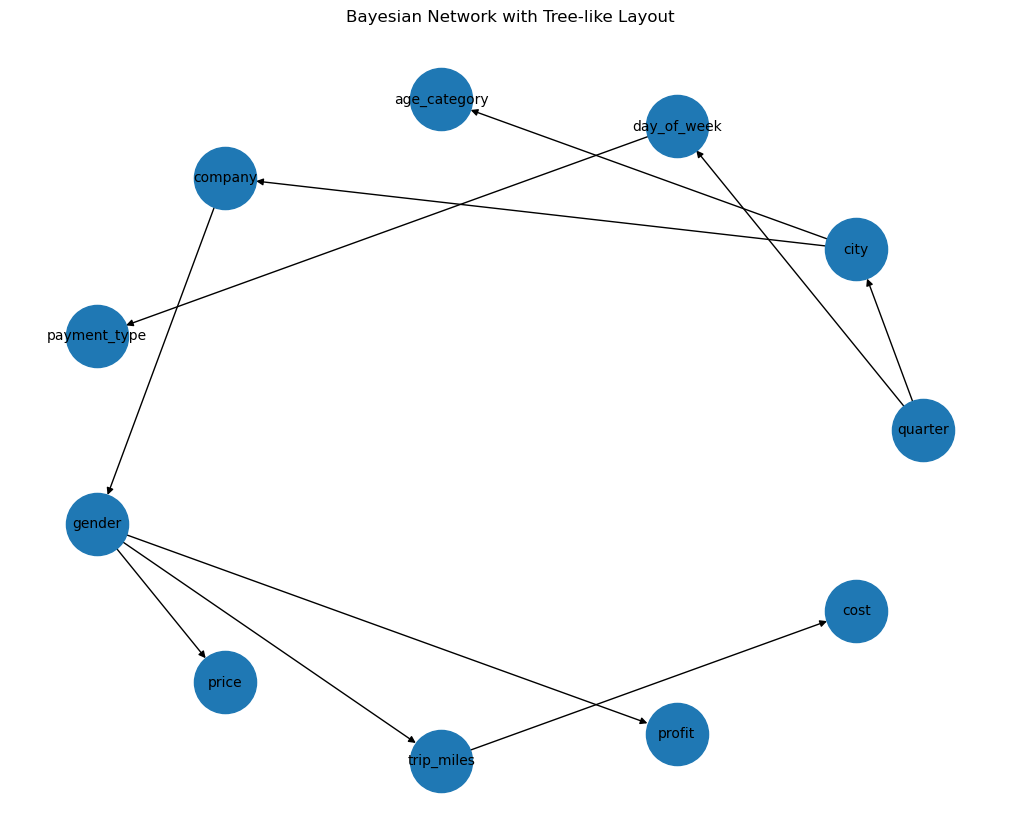

In [25]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(cab_model.nodes())

# Add edges
G.add_edges_from(cab_model.edges())

# Specify the levels of nodes for concentric circles (tree-like structure)
levels = {
    0: ['quarter'],
    1: ['city', 'day_of_week'],
    2: ['age_category', 'company', 'payment_type'],
    3: ['gender'],
    4: ['price', 'trip_miles', 'profit'],
    5: ['cost']
}

# Create a shell layout based on the levels
shell_layout = nx.shell_layout(G, nlist=[levels[level] for level in sorted(levels)])




# Visualize the graph
pos = nx.circular_layout(G)


warnings.filterwarnings("ignore")

# Draw the graph using the shell layout
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, font_color='black')
plt.title("Bayesian Network with Tree-like Layout")
plt.show()
